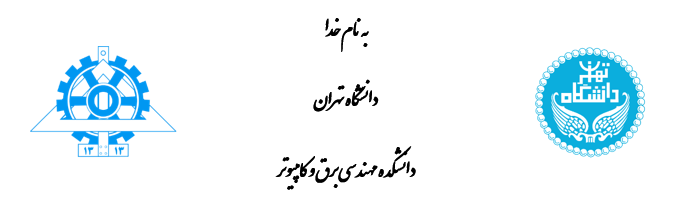
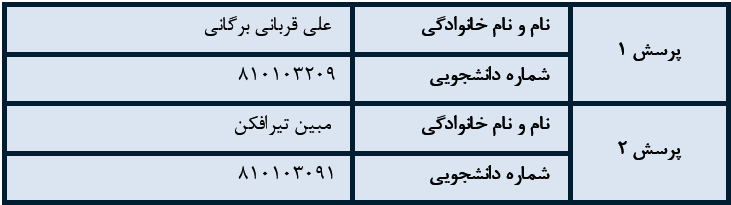

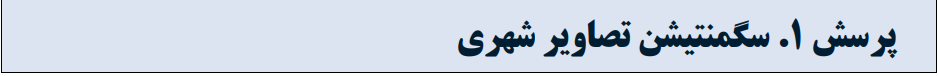

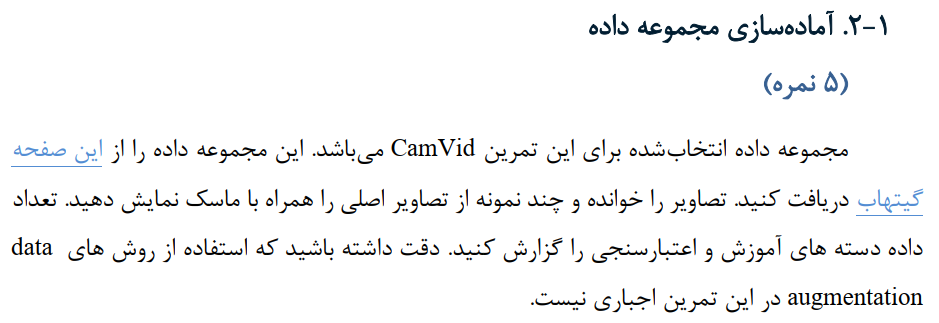

In [1]:
!git clone https://github.com/lih627/CamVid.git

Cloning into 'CamVid'...
remote: Enumerating objects: 2834, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2834 (delta 0), reused 1 (delta 0), pack-reused 2831 (from 1)
Receiving objects: 100% (2834/2834), 595.30 MiB | 37.61 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (2815/2815), done.


In [2]:
cd CamVid

/content/CamVid


In [3]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

In [4]:
root = "/content/CamVid"

# simple function to read image–mask from a file
def read_list(path):
    arr = []
    try:
        f = open(path, "r")
    except Exception as e:
        print("Error", e)
        return arr
    for line in f:
        line = line.strip()
        if line == "":
            continue
        parts = line.split()
        if len(parts) != 2:
            continue
        img = os.path.join(root, parts[0])
        mask = os.path.join(root, parts[1])
        arr.append((img, mask))
    f.close()
    return arr
# get train, validation, test lists
tr = read_list(root + "/camvid_train.txt")
va = read_list(os.path.join(root, "camvid_val.txt"))
te = read_list(os.path.join(root, "camvid_test.txt"))

print("Train Num :", len(tr))
print("Validation Num", len(va))
print("Test Num", len(te))

Train Num : 367
Validation Num 101
Test Num 233


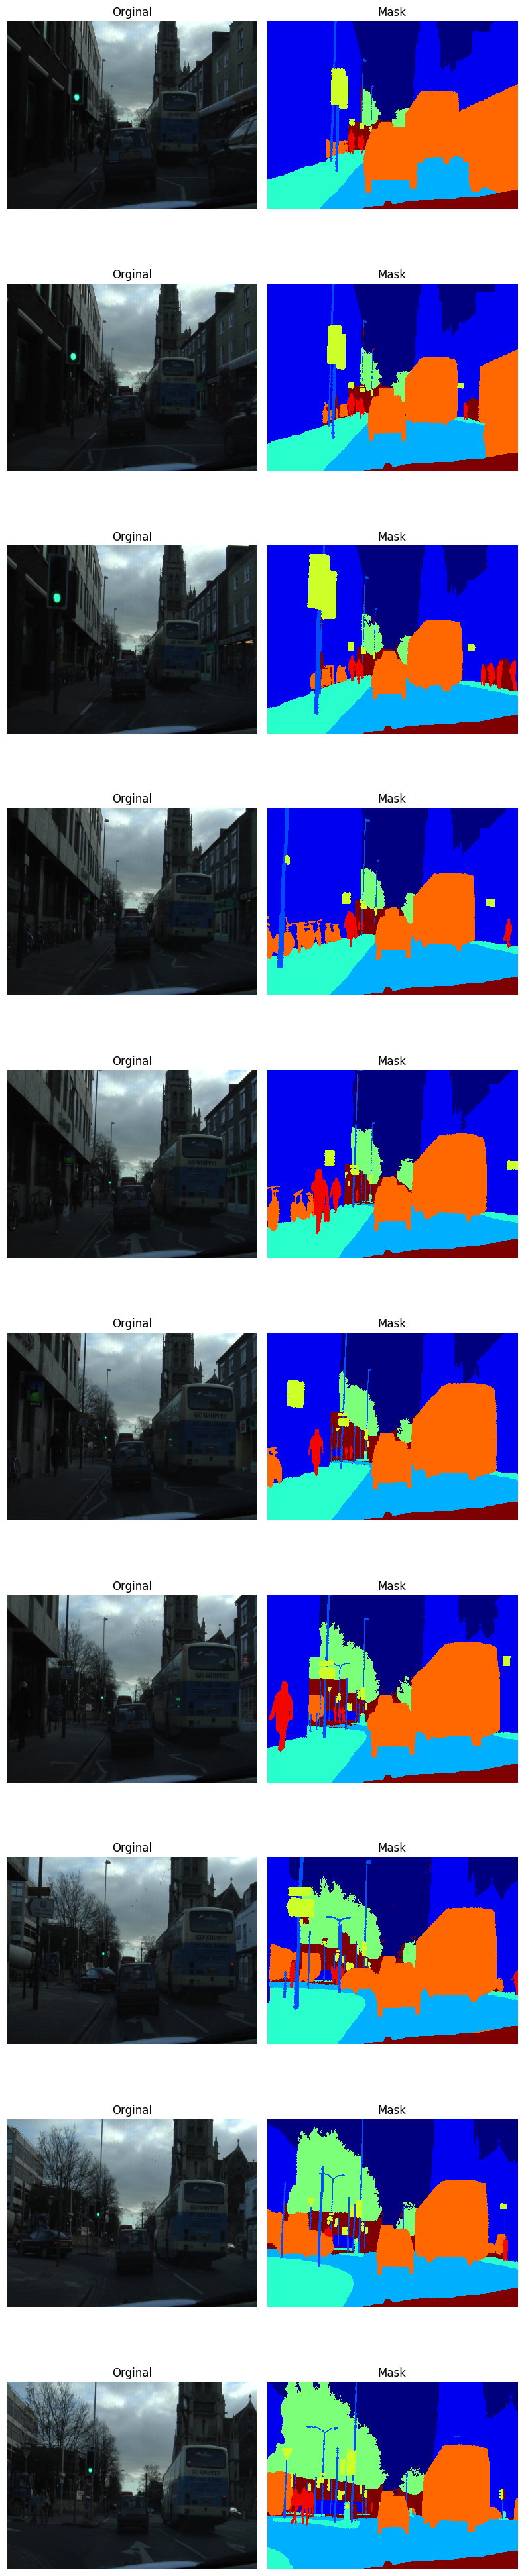

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

n = 10
fig, axes = plt.subplots(n, 2, figsize=(8, 4*n))

for i in range(n):
    p = tr[i]
    i1 = Image.open(p[0]).convert("RGB")
    m1 = Image.open(p[1])
     # display original image
    axes[i,0].imshow(i1)
    axes[i,0].set_title("Orginal")
    axes[i,0].axis("off")
    # display  mask
    axes[i,1].imshow(m1, cmap="jet", interpolation="nearest", vmin=0, vmax=10)
    axes[i,1].set_title("Mask")
    axes[i,1].axis("off")

plt.tight_layout()
plt.show()


In [6]:
import torch
import torch.nn.functional as F
 #get intersection over union scre
def iou_score(p, l, nc, ig=255, e=1e-6):
    i = []
    for c in range(nc):
        if c == ig: continue #skip
        pc = p == c # pred mask for class
        lc = l == c # true mask for class
        m  = l != ig # valid pixels only
        pc = pc & m
        lc = lc & m
        inter = (pc & lc).sum().float()  # intersection
        uni   = (pc | lc).sum().float()# union
        i.append((inter + e) / (uni + e)) #  iou
    return torch.stack(i).mean()   # mean iou
#get dice coefficient score
def dice_coef(p, l, nc, ig=255, e=1e-6):
    d = []
    for c in range(nc):
        if c == ig: continue
        pc = p == c
        lc = l == c
        m  = l != ig # like iou
        pc = pc & m
        lc = lc & m
        inter = (pc & lc).sum().float()  # intersection
        tot   = pc.sum().float() + lc.sum().float() # sum of areas
        d.append((2 * inter + e) / (tot + e)) #  dice
    return torch.stack(d).mean() # mean dice


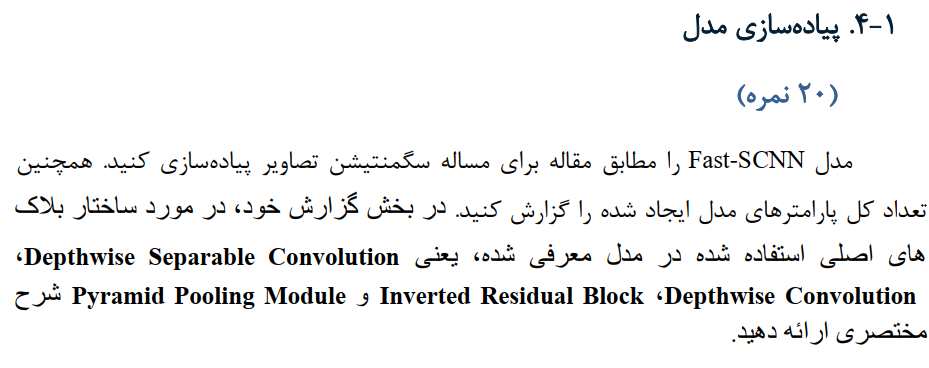

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# simple depthwise + pointwise conv block
class DConv(nn.Module):
    def __init__(self, a, b, s=1):
        super().__init__()
        self.d = nn.Conv2d(a, a, 3, stride=s, padding=1, groups=a, bias=False)
        self.p = nn.Conv2d(a, b, 1, bias=False)
        self.bn = nn.Sequential(nn.BatchNorm2d(b), nn.ReLU(True))
    def forward(self, x):
        x = self.d(x)
        x = self.p(x)
        return self.bn(x)
# inverted residual bottleneck block
class InvRes(nn.Module):
    def __init__(self, a, b, s, e):
        super().__init__()
        h = a * e
        self.r = (s == 1 and a == b)
        layers = []
        if e != 1:
            layers += [nn.Conv2d(a, h, 1, bias=False), nn.BatchNorm2d(h), nn.ReLU(True)]
        layers += [
            nn.Conv2d(h, h, 3, stride=s, padding=1, groups=h, bias=False),
            nn.BatchNorm2d(h), nn.ReLU(True),
            nn.Conv2d(h, b, 1, bias=False), nn.BatchNorm2d(b)
        ]
        self.c = nn.Sequential(*layers)
    def forward(self, x):
        if self.r:
            return x + self.c(x)   # add skip if same shape
        return self.c(x)
# pyramid pooling for multi-scale context
class PPM(nn.Module):
    def __init__(self, ch, ps=(1,2,3,6)):
        super().__init__()
        oc = ch // len(ps)
        self.st = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(p),
                nn.Conv2d(ch, oc, 1, bias=False),
                nn.BatchNorm2d(oc),
                nn.ReLU(True)
            ) for p in ps
        ])
    def forward(self, x):
        h, w = x.shape[2], x.shape[3]
        pri = [F.interpolate(m(x), (h,w), mode='bilinear', align_corners=False) for m in self.st]
        return torch.cat([x, *pri],1)
# initial downsampling path
class Down(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Sequential(nn.Conv2d(3,32,3,2,1,bias=False), nn.BatchNorm2d(32), nn.ReLU(True))
        self.d2 = DConv(32,48,2)
        self.d3 = DConv(48,64,2)
    def forward(self, x):
        x = self.c1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x
# global feature extractor using bottlenecks + PPM
class GFE(nn.Module):
    def __init__(self):
        super().__init__()
        self.bt = nn.Sequential(
            InvRes(64,64,2,6), InvRes(64,64,1,6), InvRes(64,64,1,6),
            InvRes(64,96,2,6), InvRes(96,96,1,6), InvRes(96,96,1,6),
            InvRes(96,128,1,6), InvRes(128,128,1,6), InvRes(128,128,1,6)
        )
        self.pp = PPM(128)
        self.lc = nn.Sequential(nn.Conv2d(256,128,1,bias=False), nn.BatchNorm2d(128), nn.ReLU(True))
    def forward(self, x):
        x = self.bt(x)
        x = self.pp(x)
        return self.lc(x)
# fuse high-res and low-res features
class Fuse(nn.Module):
    def __init__(self):
        super().__init__()
        self.ch = nn.Sequential(nn.Conv2d(64,128,1,bias=False), nn.BatchNorm2d(128))
        self.ll = DConv(128,128,1)
        self.rl = nn.ReLU(True)
    def forward(self, a, b):
        u = F.interpolate(b, a.shape[2:], mode='bilinear', align_corners=False)
        return self.rl(self.ch(a) + self.ll(u))
# final classifier
class Classify(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.d1 = DConv(128,128,1)
        self.d2 = DConv(128,128,1)
        self.c = nn.Conv2d(128,nc,1)
    def forward(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.c(x)
        return F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)
#  Fast-SCNN model
class FastSCNN(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.d = Down()
        self.g = GFE()
        self.f = Fuse()
        self.cl = Classify(nc)
    def forward(self, x):
        h = self.d(x)
        l = self.g(h)
        return self.cl(self.f(h, l))

if __name__=="__main__":
    m = FastSCNN(11)
    t = sum(p.numel() for p in m.parameters())
    print("Total parameters:", t)# print total parameters


Total parameters: 1135835


In [8]:
import os
from PIL import Image
import numpy as np
import torch
import torchvision.transforms.functional as TF

# simple dataset to load image and mask pairs
class CamDS(torch.utils.data.Dataset):

    def __init__(self, flist, rt, jt=None):
        self.f = flist # list of (image, mask) paths
        self.r = rt # root folder
        self.j = jt # joint transform

    def __len__(self):
        return len(self.f)

    def __getitem__(self, i):
      # build full paths for image and mask
        a, b = self.f[i]
        pa = os.path.join(self.r, a)
        pb = os.path.join(self.r, b)
         # open image and mask
        im = Image.open(pa).convert("RGB")
        mk = Image.open(pb)
         # apply transform if given
        if self.j:
            im, mk = self.j(im, mk)
            # convert image to tensor and normalize
        im = TF.to_tensor(im)
        im = TF.normalize(im, [0.485,0.456,0.406], [0.229,0.224,0.225])
         # convert mask to long tensor
        mk = torch.as_tensor(np.array(mk), dtype=torch.long)
        return im, mk


In [9]:
def read_list(x, y):
    z = []
    try:
        f = open(x, "r")
    except:
        return z
    for i in f:
        p = i.strip().split()
        if len(p) != 2:
            continue
        z.append((p[0], p[1]))
    f.close()
    return z

In [10]:
import os

r = "/content/CamVid"
tr = read_list(os.path.join(r, "camvid_train.txt"), r)
va = read_list(os.path.join(r, "camvid_val.txt"),   r)
te = read_list(os.path.join(r, "camvid_test.txt"),  r)


In [11]:
import random
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class JT:# this class do same change to image and mask
    def __init__(self, s, sc=(0.8,1.0), d=10, cj=None):
        self.s = s     # size for output
        self.sc = sc    # how much to zoom
        self.d = d        # how much to turn
        self.cj = cj    # color change tool
    def __call__(self, img, m):
      # pick crop area
        i,j,h,w = T.RandomResizedCrop.get_params(img, scale=self.sc, ratio=(1.0,1.0))
        # crop image
        img = TF.resized_crop(img, i, j, h, w, self.s, Image.BILINEAR)
         # crop mask
        m   = TF.resized_crop(m,   i, j, h, w, self.s, Image.NEAREST)
        # pick angle
        a = random.uniform(-self.d, self.d)
        # rotate image
        img = TF.rotate(img, a, Image.BILINEAR)
        # rotate mask
        m   = TF.rotate(m,   a, Image.NEAREST)
        #  flip
        if random.random()<0.5:
            img = TF.hflip(img); m = TF.hflip(m)
            #  change color
        if self.cj:
            img = self.cj(img)
        return img, m
# this class just resize both image and mask
class RT:
    def __init__(self, s):
        self.s = s
    def __call__(self, img, m):
        return TF.resize(img, self.s, Image.BILINEAR), TF.resize(m, self.s, Image.NEAREST) # make image and mask smaller or bigger


In [12]:
import torchvision.transforms as T

a = (360,480)
# transform for training
b = T.Compose([
    T.RandomResizedCrop(a, (0.8,1.0), (1.0,1.0)), # crop random
    T.RandomRotation(10),  # rotate a bit
    T.RandomHorizontalFlip(), # flip left-right
    T.ColorJitter(0.2,0.2,0.2,0.1), # change color
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),# normalize mean and std
])
# transform for val/test
c = T.Compose([
    T.Resize(a), # resize to a
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]), # normalize mean and std
])


In [13]:
b=32

jt=JT((360,480),(0.8,1.0),10,T.ColorJitter(0.2,0.2,0.2,0.1))
rt=RT((360,480))

td=CamDS(tr,root,jt)
vd=CamDS(va,root,rt)
ed=CamDS(te,root,rt)

train_loader=DataLoader(td,batch_size=b,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(vd,batch_size=b,shuffle=False,num_workers=2,pin_memory=True)
test_loader=DataLoader(ed,batch_size=b,shuffle=False,num_workers=2,pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
import torch

nc = 11
ct = torch.zeros(nc, dtype=torch.float64)
for _, m in train_loader:
    for i in range(nc):
        ct[i] += (m == i).sum().item()
fr = ct / ct.sum()
cw = 1.0 / (fr + 1e-6)
cw = (cw / cw.sum() * nc).float().to('cuda')


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

d = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m = FastSCNN(11).to(d)
l = nn.CrossEntropyLoss(cw, ignore_index=255)
o = optim.AdamW(m.parameters(), lr=1e-3, weight_decay=1e-5)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FL(nn.Module):
    def __init__(self, a=None, g=2.0, ig=255, rd='mean'):
        super().__init__()
        self.a = a
        self.g = g
        self.ig = ig
        self.rd = rd

    def forward(self, x, t):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(-1, c)
        t = t.view(-1)
        m = t != self.ig
        x = x[m]
        t = t[m]
        lp = F.log_softmax(x, 1)
        p = lp.exp()
        i = t.unsqueeze(1)
        pt = p.gather(1, i).squeeze(1)
        if self.a is not None:
            at = self.a.to(x.device).gather(0, t)
        else:
            at = 1
        l = -at * (1 - pt) ** self.g * lp.gather(1, i).squeeze(1)
        if self.rd == 'mean':
            return l.mean()
        if self.rd == 'sum':
            return l.sum()
        return l


In [18]:
cs=nn.CrossEntropyLoss(cw,ignore_index=255,label_smoothing=0.1)
fl=FL(None,2.0,255)
def cl(x,m,a=0.5):
    return a*cs(x,m)+(1-a)*fl(x,m)


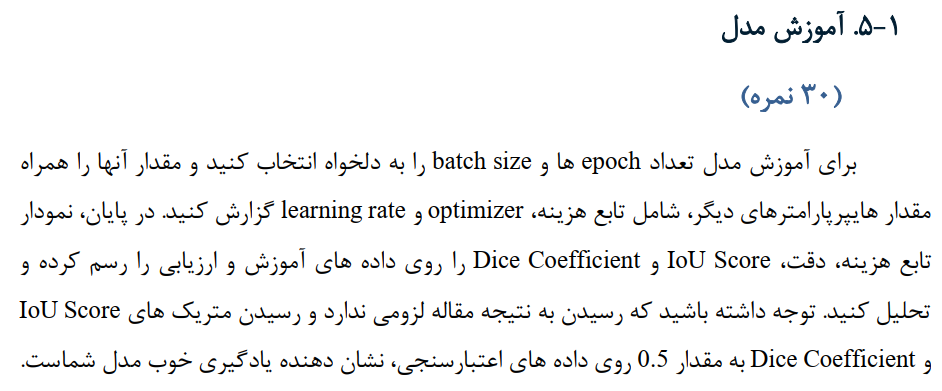

In [19]:
from torch.optim.lr_scheduler import OneCycleLR
import copy

n = 150
sc = OneCycleLR(o, max_lr=5e-4,
                steps_per_epoch=len(train_loader),
                epochs=n, pct_start=0.3,
                div_factor=10, final_div_factor=100,
                anneal_strategy='linear')
pat = 20
bvm = 0.0
ni = 0
bw = copy.deepcopy(m.state_dict())
h = {'tl': [], 'vl': [], 'miou': [], 'dice': [], 'acc': []}

for e in range(1, n+1):
    m.train()
    rl = 0.0
    for imgs, msk in train_loader:
        imgs, msk = imgs.to(d), msk.to(d)
        o.zero_grad()
        lg = m(imgs)
        ls = cl(lg, msk, 0.7)
        ls.backward()
        torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
        o.step()
        sc.step()
        rl += ls.item()
    tl = rl / len(train_loader)
    h['tl'].append(tl)

    m.eval()
    vl = 0.0
    ti, td, ta = 0.0, 0.0, 0.0
    with torch.no_grad():
        for imgs, msk in val_loader:
            imgs, msk = imgs.to(d), msk.to(d)
            lg = m(imgs)
            vl += l(lg, msk).item()
            pr = lg.argmax(dim=1)
            ti += iou_score(pr, msk, 11)
            td += dice_coef(pr, msk, 11)
            v = msk != 255
            ta += (pr[v] == msk[v]).float().mean()
    vl /= len(val_loader)
    miou = (ti / len(val_loader)).item()
    dice = (td / len(val_loader)).item()
    acc = (ta / len(val_loader)).item()
    h['vl'].append(vl); h['miou'].append(miou)
    h['dice'].append(dice); h['acc'].append(acc)

    print("[Epoch " + str(e).zfill(2) + "] TrainLoss=" + str(round(tl,4)) +
          " | ValLoss=" + str(round(vl,4)) +
          " mIoU=" + str(round(miou,4)) +
          " | Dice=" + str(round(dice,4)) +
          " | Acc=" + str(round(acc,4)))

    if miou > bvm + 1e-4:
        bvm = miou
        bw = copy.deepcopy(m.state_dict())
        ni = 0
    else:
        ni += 1
        if ni >= pat:
            print("Early stopping at epoch " + str(e) +
                  ". Best Val mIoU=" + str(round(bvm,4)))
            break


[Epoch 01] TrainLoss=3.4204 | ValLoss=2.4135 mIoU=0.0009 | Dice=0.0017 | Acc=0.0082
[Epoch 02] TrainLoss=3.2903 | ValLoss=2.3905 mIoU=0.0235 | Dice=0.0379 | Acc=0.2408
[Epoch 03] TrainLoss=3.1933 | ValLoss=2.353 mIoU=0.0449 | Dice=0.0705 | Acc=0.3124
[Epoch 04] TrainLoss=3.0879 | ValLoss=2.1879 mIoU=0.1182 | Dice=0.1593 | Acc=0.4058
[Epoch 05] TrainLoss=3.0031 | ValLoss=2.0563 mIoU=0.1633 | Dice=0.2209 | Acc=0.4695
[Epoch 06] TrainLoss=2.9268 | ValLoss=1.9388 mIoU=0.1947 | Dice=0.2627 | Acc=0.5104
[Epoch 07] TrainLoss=2.8294 | ValLoss=1.8522 mIoU=0.2133 | Dice=0.2876 | Acc=0.5446
[Epoch 08] TrainLoss=2.7579 | ValLoss=1.7719 mIoU=0.2467 | Dice=0.3358 | Acc=0.5761
[Epoch 09] TrainLoss=2.6947 | ValLoss=1.663 mIoU=0.2809 | Dice=0.38 | Acc=0.6019
[Epoch 10] TrainLoss=2.6465 | ValLoss=1.6138 mIoU=0.3136 | Dice=0.4185 | Acc=0.6334
[Epoch 11] TrainLoss=2.5837 | ValLoss=1.5644 mIoU=0.331 | Dice=0.4362 | Acc=0.6536
[Epoch 12] TrainLoss=2.5363 | ValLoss=1.5402 mIoU=0.3232 | Dice=0.427 | Acc=0.64


In [20]:
PATH = "fast_scnn.pth"
torch.save(m.state_dict(), PATH)

In [38]:
model = FastSCNN(11)         # re-create the model instance
model.load_state_dict(torch.load("fast_scnn.pth"))  # load weights
model.eval()

FastSCNN(
  (d): Down(
    (c1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (d2): DConv(
      (d): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
      (p): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): Sequential(
        (0): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
      )
    )
    (d3): DConv(
      (d): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=48, bias=False)
      (p): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
      )
    )
  )
  (g): GFE(
    (bt): Sequenti

In [21]:
import torch
torch.save(h, "history.pth")

In [ ]:
h = torch.load("history.pth")

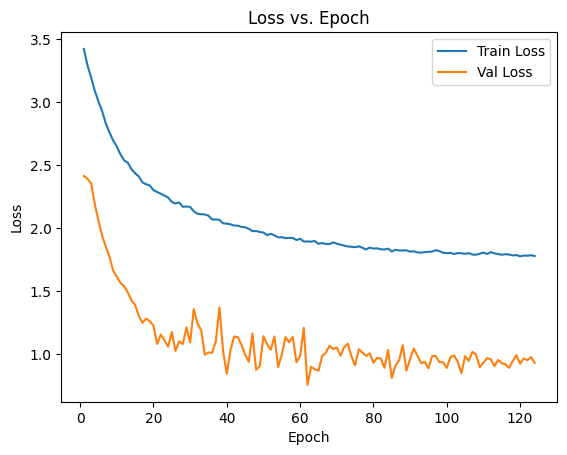

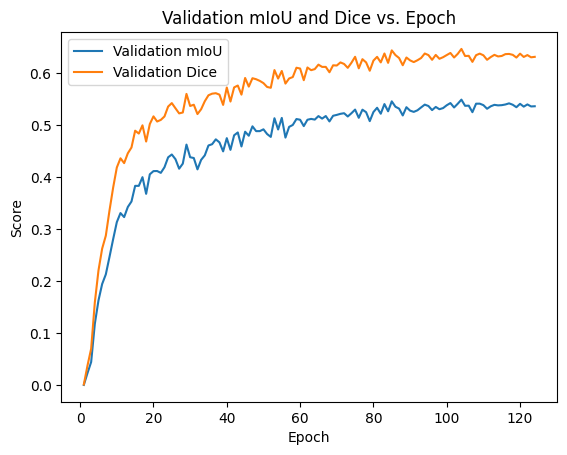

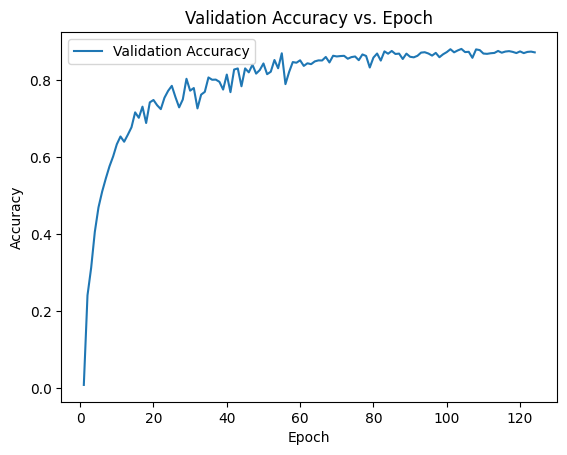

In [22]:
import matplotlib.pyplot as plt

e = range(1, len(h['tl'])+1)
plt.figure()
plt.plot(e, h['tl'], label='Train Loss')
plt.plot(e, h['vl'], label='Val Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(e, h['miou'], label='Validation mIoU')
plt.plot(e, h['dice'], label='Validation Dice')
plt.title('Validation mIoU and Dice vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.figure()
plt.plot(e, h['acc'], label='Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


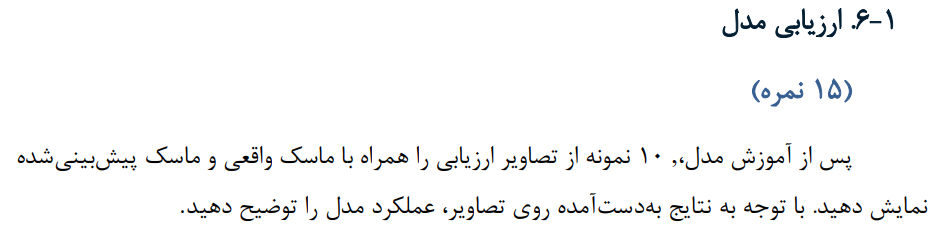

In [33]:
model.to(d)
model.eval()
a=0.0; b=0.0; c=0.0
with torch.no_grad():
    for x,y in test_loader:
        x,y=x.to(d),y.to(d)
        o=model(x)
        p=o.argmax(1)
        a+=iou_score(p,y,11)
        b+=dice_coef(p,y,11)
        mo=y!=255
        c+=(p[mo]==y[mo]).float().mean()
n=len(test_loader)
print("\nTest Results → mIoU: {:.4f} | Dice: {:.4f} | Acc: {:.4f}".format((a/n).item(),(b/n).item(),(c/n).item()))



Test Results → mIoU: 0.3975 | Dice: 0.4952 | Acc: 0.7779


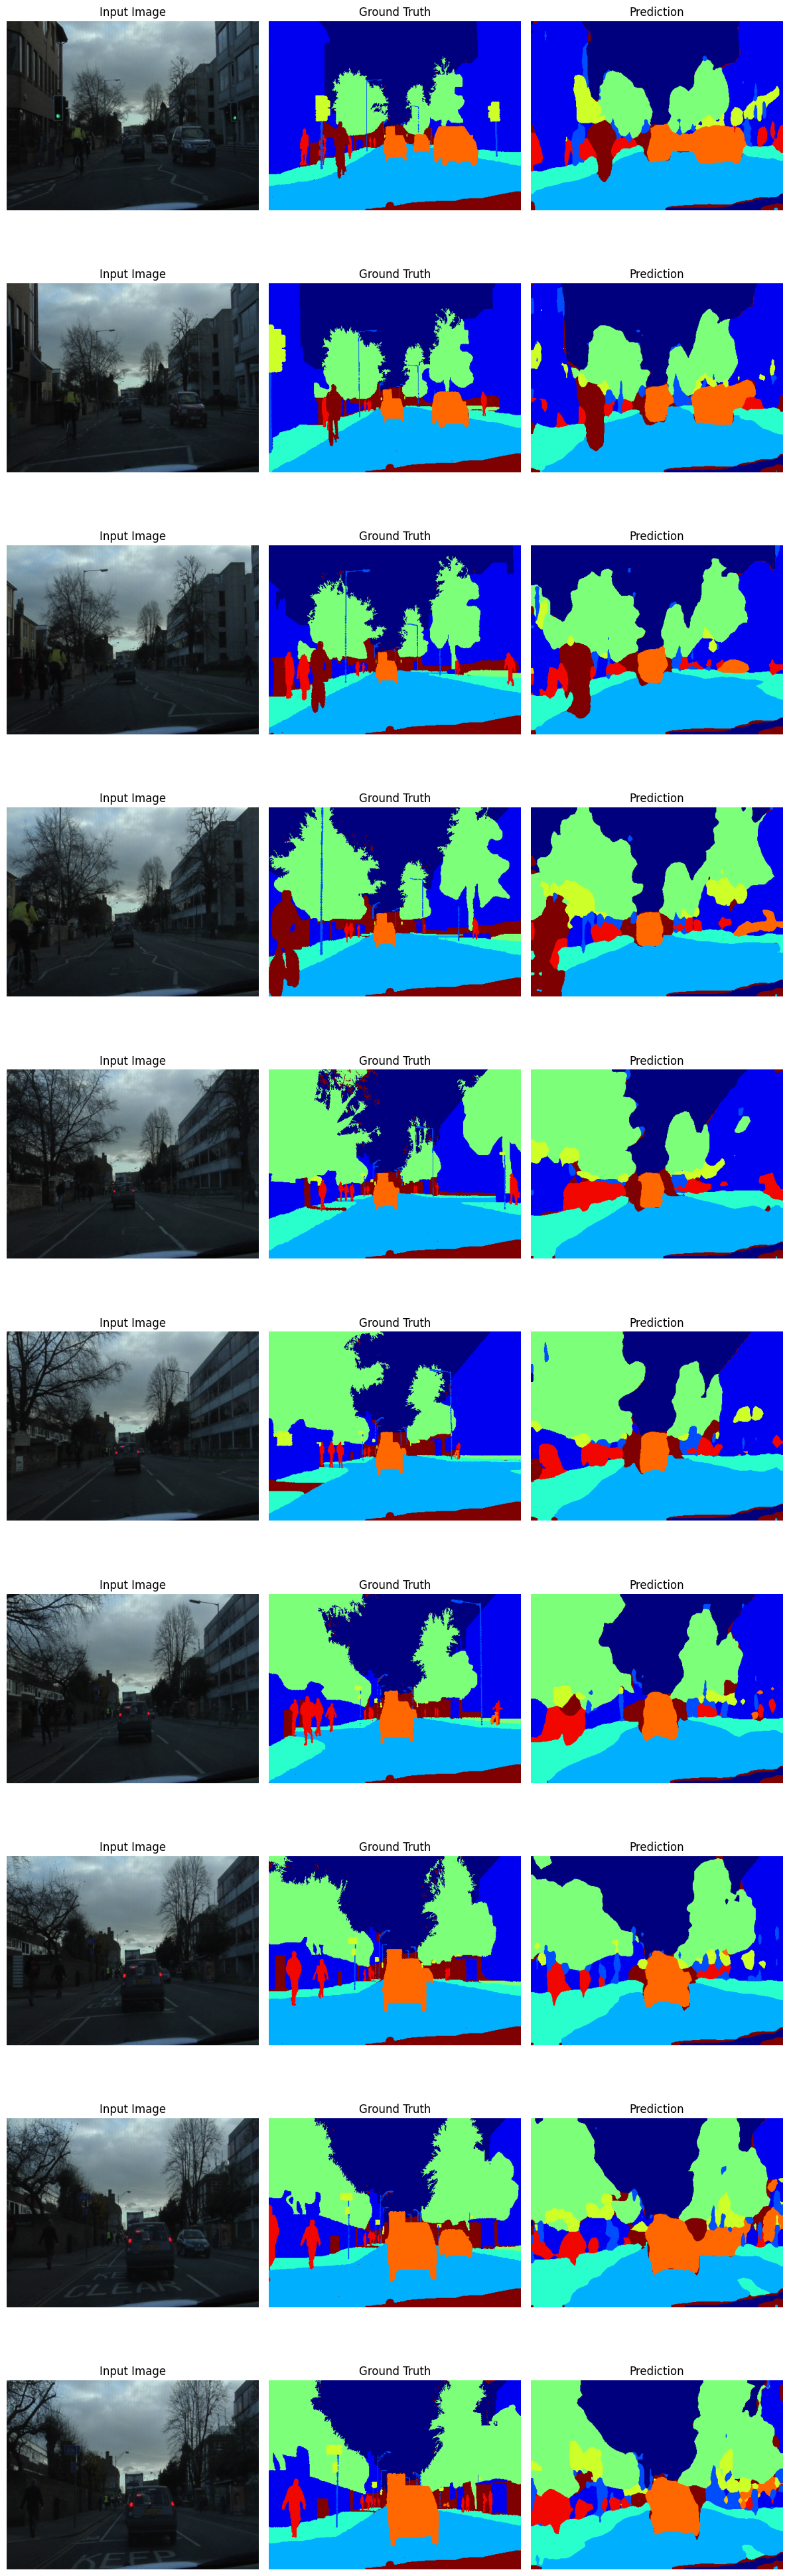

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()
ns=10
f,a=plt.subplots(ns,3,figsize=(12,4*ns))
s=0
with torch.no_grad():
    for im,mk in test_loader:
        im,mk=im.to(d),mk.to(d)
        lg=model(im)
        pr=lg.argmax(1)
        for j in range(im.size(0)):
            if s>=ns: break
            x=im[j].cpu().permute(1,2,0).numpy()
            m=np.array([0.485,0.456,0.406]);d=np.array([0.229,0.224,0.225])
            x=(x*d+m).clip(0,1)
            g=mk[j].cpu().numpy();p=pr[j].cpu().numpy()
            a[s,0].imshow(x);a[s,0].set_title("Input Image");a[s,0].axis("off")
            a[s,1].imshow(g,cmap="jet",vmin=0,vmax=10);a[s,1].set_title("Ground Truth");a[s,1].axis("off")
            a[s,2].imshow(p,cmap="jet",vmin=0,vmax=10);a[s,2].set_title("Prediction");a[s,2].axis("off")
            s+=1
        if s>=ns: break
plt.tight_layout();plt.show()


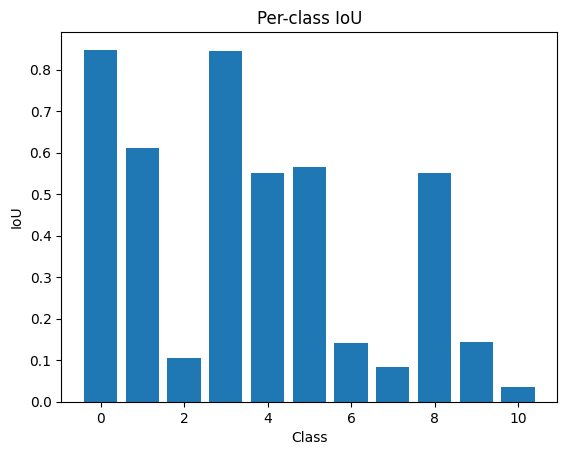

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score
import torchvision.transforms.functional as TF

nc = 11  # number of classes
ignore_idx = 255

# --- 1) Per-class IoU and bar chart ---
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, masks in test_loader:
        #imgs, masks = imgs.to(d), masks.to(d)
        logits = model(imgs)
        preds = logits.argmax(dim=1)
        mask_valid = masks != ignore_idx
        all_preds.append(preds[mask_valid].cpu().numpy().ravel())
        all_labels.append(masks[mask_valid].cpu().numpy().ravel())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

ious = []
for c in range(nc):
    pred_c = (y_pred == c)
    true_c = (y_true == c)
    inter = np.logical_and(pred_c, true_c).sum()
    uni   = np.logical_or(pred_c, true_c).sum()
    ious.append((inter + 1e-6) / (uni + 1e-6))

plt.figure()
plt.bar(range(nc), ious)
plt.xlabel("Class")
plt.ylabel("IoU")
plt.title("Per-class IoU")
plt.show()

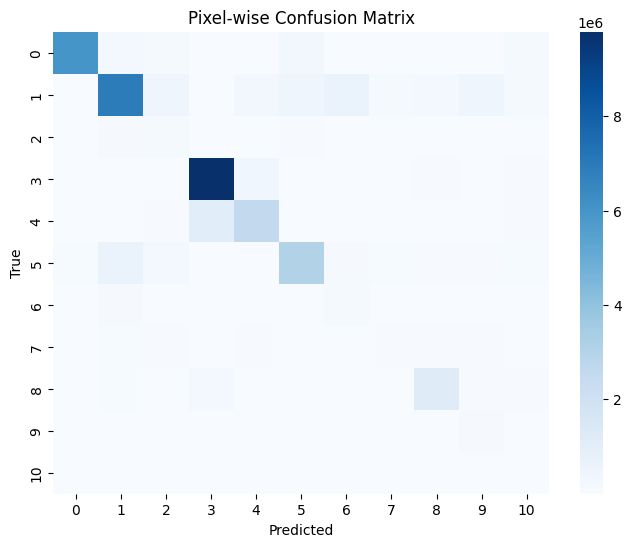

In [42]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(nc)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Pixel-wise Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


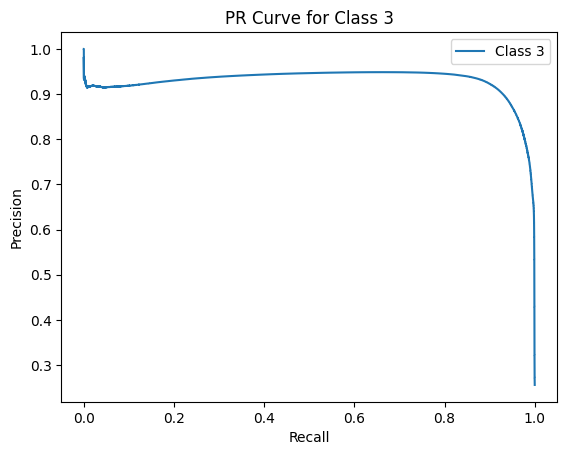

In [45]:
c = 3
probs_list = []
labels_list = []
model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        #imgs, masks = imgs.to(d), masks.to(d)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:, c, :, :].cpu().numpy().ravel()
        mask_c = (masks.cpu().numpy().ravel() == c).astype(int)
        probs_list.append(probs)
        labels_list.append(mask_c)

probs_all = np.concatenate(probs_list)
labels_all = np.concatenate(labels_list)
p, r, _ = precision_recall_curve(labels_all, probs_all)
plt.figure()
plt.plot(r, p, label=f"Class {c}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve for Class {c}")
plt.legend()
plt.show()

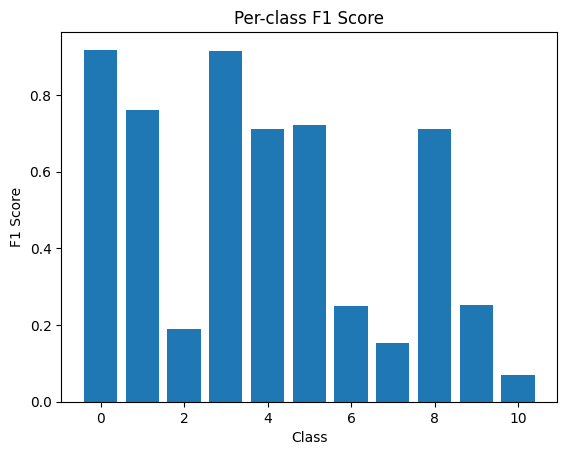

In [46]:
f1s = []
for c in range(nc):
    f1s.append(f1_score(y_true == c, y_pred == c))
plt.figure()
plt.bar(range(nc), f1s)
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("Per-class F1 Score")
plt.show()

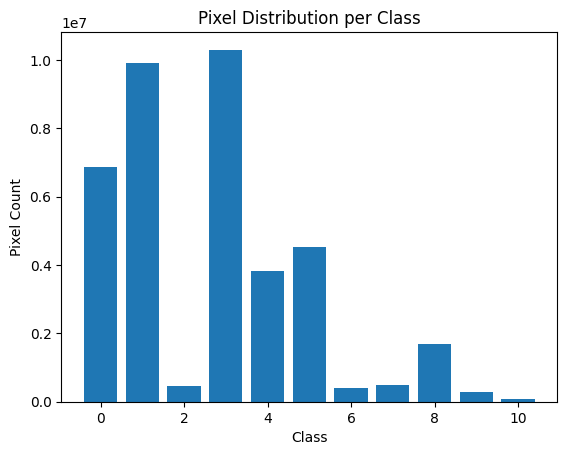

In [47]:
counts = np.bincount(y_true, minlength=nc)
plt.figure()
plt.bar(range(nc), counts)
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.title("Pixel Distribution per Class")
plt.show()